# Week 3 - Offshore Wind

In [60]:
import importlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandera as pa
from frictionless.program.common import sample_size
from matplotlib.markers import MarkerStyle

import schemas.wind_schema_1

eval_file = './resources/wind_data/bbdc_2018/eval-en.csv'

def object_to_date(x):
    # date value example
    # 2017-07-01 01:30:00
    return pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S')

pd_converters = {'Date': object_to_date}

input_df = pd.read_csv(eval_file, converters=pd_converters)

# infer a schema for data validation
inferred_schema = pa.infer_schema(input_df)
with open('./schemas/wind_schema_1.py', 'w') as file:
    file.write(inferred_schema.to_script())

# validate dataframe after checking the schema manually
try:
    print("validating...")
    importlib.reload(schemas.wind_schema_1)
    schemas.wind_schema_1.schema.validate(input_df, lazy=True)
except pa.errors.SchemaErrors as e:
    print(e)
else:
    print("validation passed")

validating...
validation passed


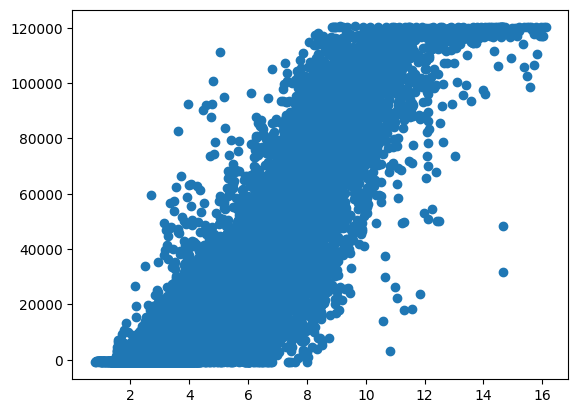

In [10]:
# plot output vs wind speed
plt.scatter(input_df['wind_speed48M'], input_df['Output'])
plt.show()

We expect a sigmoid regression, since the power output from a wind turbine should, as the wind speed goes from low to high:
- stay low until mechanical resistance, friction, and inertia of rest are overcome
- increase uniformly, then
- plateau, since there are limiters in place to protect the turbine components in high wind, and physical limitations on how much power the device can generate (at a certain point, higher wind speed won't spin the turbine blades any faster, resistance in wires increases as they carry more current and heat up, friction in the mechanical components counteracts movement as they speed up, etc.)

x_max=np.float64(16.12), x_min=np.float64(0.79), x_mean=np.float64(5.657745358840842)
(17668,)
y_max=np.int64(120460), y_min=np.int64(-976), y_mean=np.float64(30024.976001811185)
Fitted Parameters: beta_0 = 7.75, beta_1 = 21538.0


/var/folders/6x/wkl1tz7x4lv2t19tnbq3drhm0000gn/T/ipykernel_41368/211014355.py:36: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(sigmoid, x_data, y_data, p0=p_init)  # Initial guesses for beta_0 and beta_1


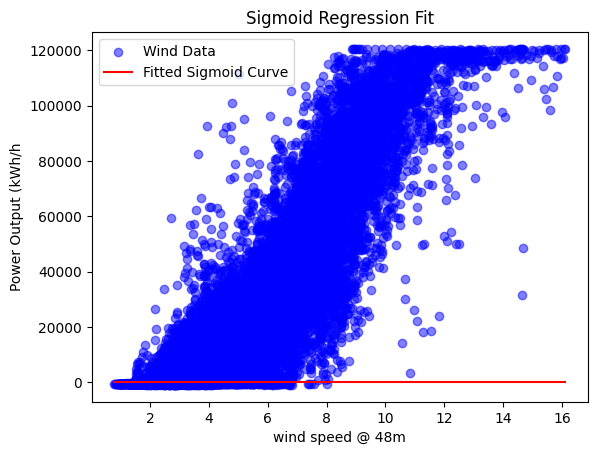

Optimal parameters (scaled): [-4.37514943  9.21027316]


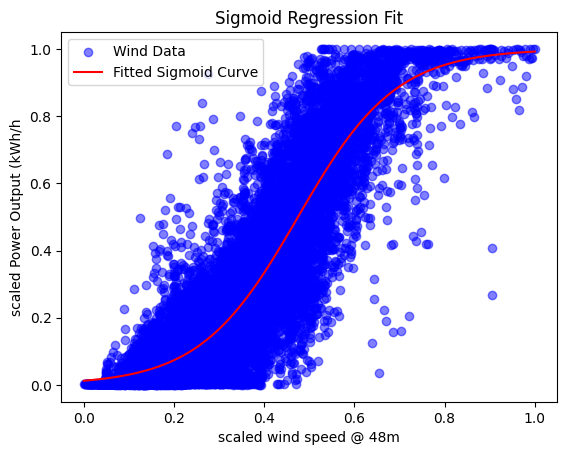

In [64]:
# scipy has a curve-fitting feature
from scipy.optimize import curve_fit



# scikit-learn has a logistic regression feature
# from sklearn.linear_model import LogisticRegression

x_data = input_df['wind_speed48M'].to_numpy()
x_max = np.max(x_data)
x_min = np.min(x_data)
x_mean = np.mean(x_data)
print(f"{x_max=}, {x_min=}, {x_mean=}")
print(x_data.shape)
# y = input_df['Output'].to_numpy().reshape(-1, 1)
# y = input_df['Output'].to_numpy().ravel()
y_data = input_df['Output'].to_numpy()
y_max = input_df['Output'].max()
y_min = input_df['Output'].min()
y_mean = input_df['Output'].mean()
print(f"{y_max=}, {y_min=}, {y_mean=}")



# Define the sigmoid function
def sigmoid(x, beta_0, beta_1):
    return 1 / (1 + np.exp(-(beta_0 + beta_1 * x)))

# Fit the sigmoid curve to the data
# select initial gues for the midpoint (beta_0) and slope (beta_1) for the sigmoid curve
# p_init = [x_data.mean(), 1]
# initial x value at apx. y_mean: 7.75
# (9, 90_000) - (5.75, 20_000)
# initial slope: 70_000/3.25 = 21_538
p_init = [7.75, 21_538]
popt, _ = curve_fit(sigmoid, x_data, y_data, p0=p_init)  # Initial guesses for beta_0 and beta_1

# Extract fitted parameters
beta_0, beta_1 = popt
print(f"Fitted Parameters: beta_0 = {beta_0}, beta_1 = {beta_1}")

# Generate the fitted sigmoid curve
x_fit = np.linspace(x_data.min(), x_data.max(), 100)  # Predictor variable for smooth curve
# x_fit = x_data  # Predictor variable for smooth curve
y_fit = sigmoid(x_fit, beta_0, beta_1)

# Plot original data and the fitted sigmoid curve
plt.scatter(x_data, y_data, color='blue', label="Wind Data", alpha=0.5)
plt.plot(x_fit, y_fit, color='red', label="Fitted Sigmoid Curve")
plt.xlabel("wind speed @ 48m")
plt.ylabel("Power Output (kWh/h")
plt.legend()
plt.title("Sigmoid Regression Fit")
plt.show()

# try with scaling
from sklearn.preprocessing import MinMaxScaler

x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
x_data_scaled = x_scaler.fit_transform(x_data.reshape(-1, 1)).ravel()
y_data_scaled = y_scaler.fit_transform(y_data.reshape(-1, 1)).ravel()

# Fit sigmoid to the scaled data
popt, pcov = curve_fit(sigmoid, x_data_scaled, y_data_scaled, p0=[0.5, 0.1])

# Transform the fit results back if needed
print("Optimal parameters (scaled):", popt)
beta_0, beta_1 = popt

# Generate the fitted sigmoid curve
x_fit = np.linspace(x_data_scaled.min(), x_data_scaled.max(), 100)  # Predictor variable for smooth curve
# x_fit = x_data  # Predictor variable for smooth curve
y_fit = sigmoid(x_fit, beta_0, beta_1)

# Plot original data and the fitted sigmoid curve
plt.scatter(x_data_scaled, y_data_scaled, color='blue', label="Wind Data", alpha=0.5)
plt.plot(x_fit, y_fit, color='red', label="Fitted Sigmoid Curve")
plt.xlabel("scaled wind speed @ 48m")
plt.ylabel("scaled Power Output (kWh/h")
plt.legend()
plt.title("Sigmoid Regression Fit")
plt.show()


